In [1]:
import time
import numpy as np

from astropy.time import Time   # Astropy 4.1rc1 is used

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from orbdet.utils.utils import *
from orbdet.utils.utils_vis import *
from orbdet.utils.utils_aux import *

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=2)

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=1, frame='teme')

print((x_obs_multiple.shape))

# Define measurements
r_1, rr_1 = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple[:,:,0])
r_2, rr_2 = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple[:,:,1])
r_3, rr_3 = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple[:,:,2])
z_rr_1 = np.expand_dims(rr_1, axis=0)       # Range rate measurements
_, z_rr_multiple = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)
z_x_sat = x_sat_orbdyn_stm                  # Full state measurements


(6, 421, 3)


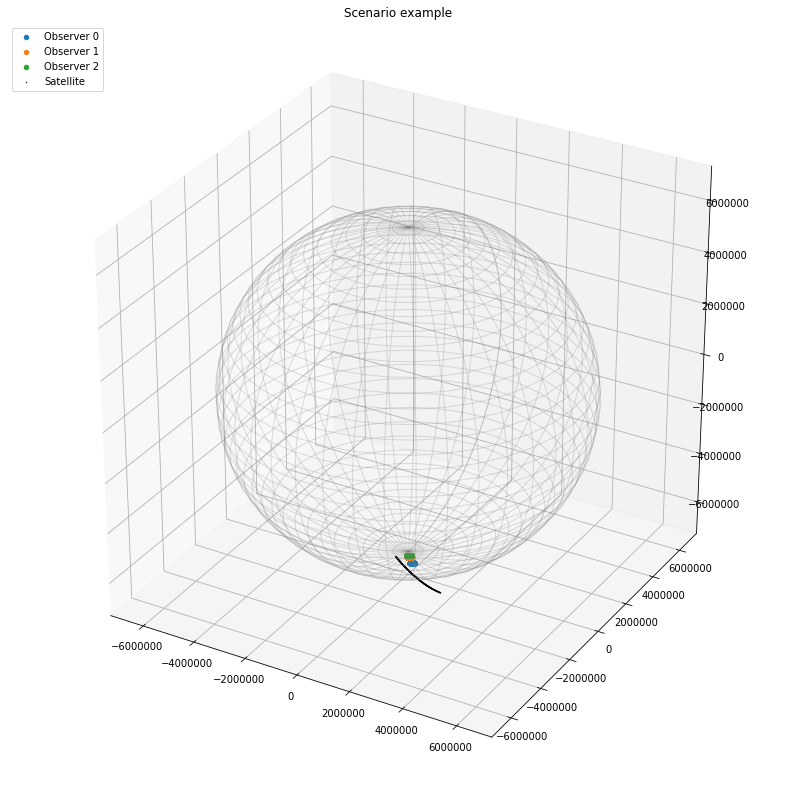

In [2]:
fig1 = plot_example_3d(x_sat_orbdyn_stm, x_obs_multiple)

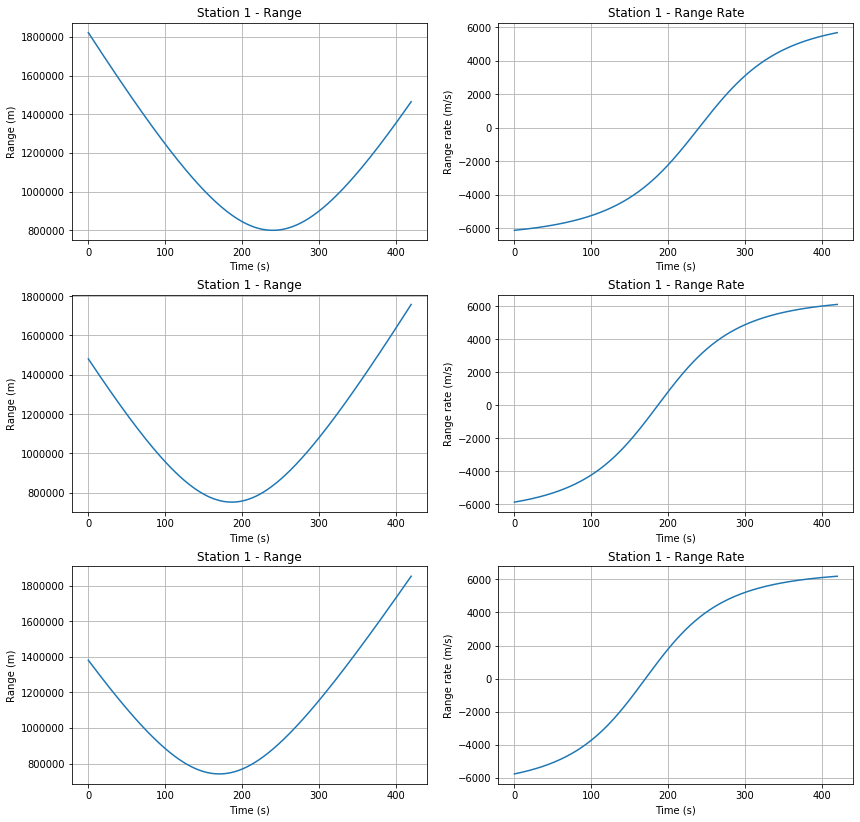

In [3]:
fig2 = plot_range_range_rate(x_sat_orbdyn_stm, x_obs_multiple, t_sec)

In [4]:
# Matrices
R_rr_1 = np.eye(1)*1e-6       # Measurement uncertainty range rate (1x1)
R_rr = np.eye(x_obs_multiple.shape[2])*1e-6       # Measurement uncertainty range rate (array)
R_x_sat = np.eye(6)*1e-12     # Measurement uncertainty full state

P_small = np.eye(6)*1e-6                         # Initial state uncertainty - small
P = np.diag([1e4, 1e4, 1e4, 1e2, 1e2, 1e2])      # Initial uncertainty - random guess
P = np.diag([1,1,1,1,1,1])*1e5      # Initial uncertainty - random guess

# Random sampling
n_samples = 100
x_0r = np.random.multivariate_normal(x_0.squeeze(), P, n_samples).T
x_0err = x_0r - x_0

verbose = True

start_time = time.time()
#####   Batch Test 2_1 - Range rate, random samples, multiple measurements     #####
run_batch_2_1 = True
if run_batch_2_1 == True:     

    x_br = np.zeros(x_0r.shape)
    x_berr = np.zeros(x_0r.shape)
    if verbose:
        print(f"Batch 2_1 Output:")

    for i in range(n_samples):

        x_b, output = batch(
            np.copy(np.expand_dims(x_0r[:,i], axis=1)), P, R_rr, z_rr_multiple, t_sec, x_obs_multiple, 
            f_obs=f_obs_range_rate, tolerance=1e-8, max_iterations=100)
        x_br[:,i] = x_b.squeeze()
        x_berr[:,i] = (x_0 - x_b).squeeze()
        x_berr1 = (x_0 - x_b).T

        if verbose:
            print(f"{i} Number of iterations", output['num_it'])
            print(f"err_1: \t{x_0err[:,i]}, Norm pos {np.linalg.norm(x_0err[0:3,i])}, \
                Norm vel {np.linalg.norm(x_0err[3:6,i])}")
            print(f"err_2: \t{x_berr1}, Norm pos {np.linalg.norm(x_berr1[0:3])}, \
                Norm vel {np.linalg.norm(x_berr[3:6])}")

print(f"Elapsed {(time.time()-start_time):.2f} s")


            Norm vel 538.1908852665531
err_2: 	[[-4.70e-05 -9.78e-06 -1.39e-05  9.83e-08 -8.66e-09  3.37e-08]], Norm pos 5.000971180008997e-05,                 Norm vel 1.2138273858404865e-06
36 Number of iterations 9
err_1: 	[ 133.91  -50.44  392.46  526.06 -209.32 1095.8 ], Norm pos 417.7375499567425,                 Norm vel 1233.4226277371808
err_2: 	[[-5.75e-05 -1.59e-05 -2.25e-05  1.20e-07  1.37e-08  5.79e-08]], Norm pos 6.376044694477377e-05,                 Norm vel 1.2212177492229884e-06
37 Number of iterations 8
err_1: 	[ 123.78  103.48  -98.46 -450.52 -197.6   -34.78], Norm pos 189.01076843049452,                 Norm vel 493.1741864182674
err_2: 	[[-3.33e-05 -9.24e-06 -6.79e-06  6.55e-08 -1.81e-08  2.22e-10]], Norm pos 3.520825632253578e-05,                 Norm vel 1.2231084242220154e-06
38 Number of iterations 10
err_1: 	[ 301.35 -310.97 -346.13  -76.32 -188.19 -310.79], Norm pos 554.363527087725,                 Norm vel 371.25852461481935
err_2: 	[[-3.84e-05  8.52e-07  

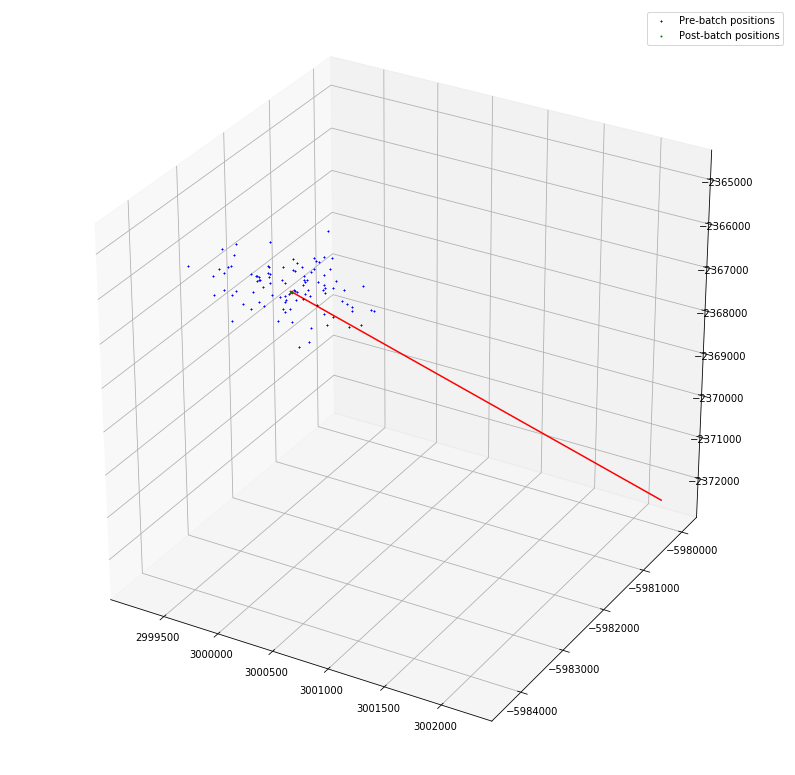

In [5]:
fig = plot_batch_results(x_sat_orbdyn_stm, x_0r, x_br, x_berr)